To simulate the arrival of patients and bed assignment, a sample of 500 clients from the original dataset is used and arrival days are assigned randomly over the course of a month.

In [52]:
# Import libraries
import joblib
import numpy as np
import pandas as pd

In [53]:
# Load the trained pipeline
pipeline = joblib.load(r"C:\CodigosGithub\Hospital_LOS_Prediction\models\xgb_final_pipeline.pkl")
print("Model pipeline loaded.")

# Load your full cleaned dataset (replace with full path if needed)
df_full = pd.read_csv(r"C:\CodigosGithub\Hospital_LOS_Prediction\data\hospital_cleaned.csv")

# Simulate a batch of incoming patients
n_patients = 500
np.random.seed(123)
new_patients = df_full.sample(n=n_patients, random_state=123).copy()

Model pipeline loaded.


In [54]:
# Define feature columns 
categorical_features = [
    'age_group', 'gender', 'race', 'ethnicity',
    'type_of_admission', 'patient_disposition',
    'ccsr_diagnosis_description', 'apr_severity_of_illness_description',
    'apr_risk_of_mortality', 'apr_medical_surgical_description',
    'payment_typology_1', 'emergency_department_indicator'
]


# Predict LOS and round it up
new_patients['predicted_los'] = np.ceil(
    pipeline.predict(new_patients[categorical_features])
).astype(int)


In [55]:
# Assign the day of admission randomly
new_patients['day_of_admission'] = np.random.randint(0, 60, size=n_patients)

In [56]:
# Define simulation window
simulation_days = 60
bed_occupancy = np.zeros(simulation_days)

# Project daily bed usage
for _, row in new_patients.iterrows():
    start = row['day_of_admission']
    end = min(start + row['predicted_los'], simulation_days)
    bed_occupancy[start:end] += 1


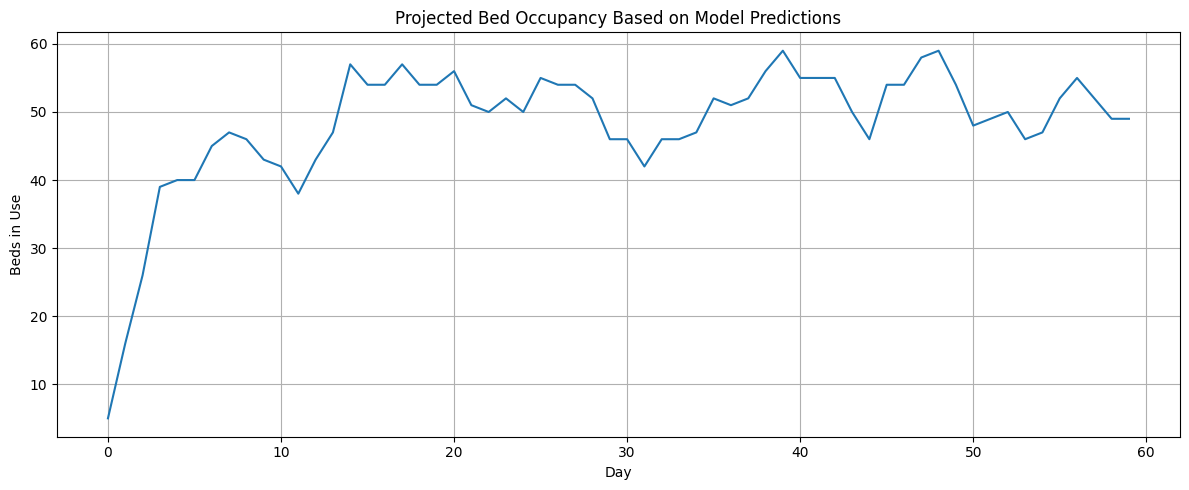

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(bed_occupancy)
plt.title("Projected Bed Occupancy Based on Model Predictions")
plt.xlabel("Day")
plt.ylabel("Beds in Use")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optimization Model: Hospital Bed Assignment

This optimization model assigns incoming patients to available hospital beds based on their **predicted length of stay (LOS)** and **day of admission**, as forecasted by a machine learning model.

### Objective
Minimize the **total number of beds used** while ensuring that no two patients are assigned to the same bed if their hospital stays overlap.

We define the following:

- $x_{ij} = 1 $ if patient $ i $ is assigned to bed $j$, 0 otherwise  
- $y_j = 1$ if bed $j$ is used, 0 otherwise  
- $\text{start}_i$ = admission day of patient $i$  
- $\text{end}_i$ = discharge day of patient $i$ = $\text{start}_i + \text{LOS}_i$


### Mathematical Formulation

**Objective Function**:

$\min \sum_{j=1}^{B} y_j$

Where $B$ is the maximum number of beds available for assignment.

**Constraints**:

1. **Each patient must be assigned to exactly one bed**:

$\sum_{j=1}^{B} x_{ij} = 1 \quad \forall i \in \{1, \dots, N\}$

Where $N$ is the number of patients.


2. **No overlapping patients in the same bed**:  
If patients $i$ and $k$ have overlapping stays, they **cannot** be assigned to the same bed \( j \):

$x_{ij} + x_{kj} \leq y_j \quad \text{if } [\text{start}_i, \text{end}_i) \cap [\text{start}_k, \text{end}_k) \neq \emptyset$

This ensures that the bed is used only once at a time.

---

3. **Binary variables**:


$x_{ij} \in \{0, 1\}, \quad y_j \in \{0, 1\}$



---

### Implementation Notes

- The model is implemented using **Mixed Integer Linear Programming (MILP)** via the [PuLP](https://coin-or.github.io/pulp/) library in Python.
- A high upper bound (e.g., 200 beds) is assumed for bed availability; the optimizer will only use what's necessary.
- `day_of_admission` is assigned randomly in a simulation window (e.g., 60 days).
- `predicted_los` is based on machine learning predictions from real patient data.

---

> **Note:** This model assumes a fixed admission schedule and known LOS. In real-world applications, uncertainty and urgent admissions would require dynamic or probabilistic models.


In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, value

# Maximum number of beds to consider in the model (upper bound)
max_beds = 200  

# Create optimization model
model = LpProblem("Optimal_Bed_Assignment", LpMinimize)

# Decision variables: x[i, j] = 1 if patient i is assigned to bed j
x = {
    (i, j): LpVariable(f"x_{i}_{j}", cat=LpBinary)
    for i in range(n_patients)
    for j in range(max_beds)
}

# Binary variables: y[j] = 1 if bed j is used
y = {
    j: LpVariable(f"y_{j}", cat=LpBinary)
    for j in range(max_beds)
}

# -------------------------
# Objective: Minimize total number of beds used
# -------------------------
model += lpSum(y[j] for j in range(max_beds))

# -------------------------
# Constraint 1: Each patient is assigned to exactly one bed
# -------------------------
for i in range(n_patients):
    model += lpSum(x[i, j] for j in range(max_beds)) == 1

# -------------------------
# Constraint 2: Prevent overlapping stays in the same bed
# -------------------------
for j in range(max_beds):
    for i in range(n_patients):
        for k in range(i + 1, n_patients):

            # Extract admission and discharge days
            i_start = new_patients.iloc[i]['day_of_admission']
            i_end = i_start + new_patients.iloc[i]['predicted_los']
            k_start = new_patients.iloc[k]['day_of_admission']
            k_end = k_start + new_patients.iloc[k]['predicted_los']

            # If their stays overlap
            if not (i_end <= k_start or k_end <= i_start):
                # Then they cannot share the same bed
                model += x[i, j] + x[k, j] <= y[j]

# -------------------------
# Solve the model
# -------------------------
print("Solving the optimization problem...")
model.solve()
print("Optimization completed.")

# -------------------------
# Get the total number of beds used
# -------------------------
used_beds = int(sum(value(y[j]) for j in y))
print(f"Optimal number of beds needed: {used_beds}")


Solving the optimization problem...


In [ ]:
# Create a DataFrame of patient-bed assignments
assignments = []

for i in range(n_patients):
    for j in range(max_beds):
        if value(x[i, j]) == 1:
            assignments.append({
                'Patient': i,
                'Assigned Bed': j,
                'Day In': new_patients.iloc[i]['day_of_admission'],
                'LOS': new_patients.iloc[i]['predicted_los'],
                'Day Out': new_patients.iloc[i]['day_of_admission'] + new_patients.iloc[i]['predicted_los']
            })

df_assignments = pd.DataFrame(assignments)
df_assignments.head()


,Patient,Assigned Bed,Day In,LOS,Day Out
0,0,21,13,3,16
1,1,21,2,6,8
2,2,198,12,3,15
3,3,115,2,3,5
4,4,115,6,12,18



The model created proved successful, finding the optimal solution when tested for small groups of patients (10 and 20). However, the time it takes to reach optimality increases rapidly beyond this number, for various reasons. Currently, this model is running for 500 patients; however, it has been running for over 35 hours.

# Why the MILP Optimization Model Is Slow

MILP becomes **computationally expensive** when:
- You have a large number of patients (e.g., 500+)
- The planning horizon includes many time steps (e.g., 60 days)
- You include one binary variable per (patient × bed × day) combination

This leads to thousands (or millions) of binary variables, which are slow to solve even with powerful solvers, so it is an NP-Hard problem.

## Alternative 

Due to the exponential growth in the number of constraints and variables when using MILP with PuLP for large-scale scenarios (e.g., 500+ patients), the solver becomes computationally infeasible. For this reason, we replaced it with a greedy heuristic that significantly reduces computational cost while maintaining feasible and practical solutions.


## Summary
- Implemented a greedy heuristic for bed allocation based on predicted Length of Stay (LOS).
- Visualized bed occupancy and assignment timeline.
- Achieved a feasible solution for large-scale patient batches (e.g., 500+).
- Next steps include testing metaheuristics (e.g., Genetic Algorithms) for performance comparison.
